# Custom Display Logic

## Overview

As described in the [Rich Output](Rich Output.ipynb) tutorial, the IPython display system can display rich representations of objects in the following formats:

* JavaScript
* HTML
* PNG
* JPEG
* SVG
* LaTeX
* PDF

This Notebook shows how you can add custom display logic to your own classes, so that they can be displayed using these rich representations. There are two ways of accomplishing this:

1. Implementing special display methods such as `_repr_html_` when you define your class.
2. Registering a display function for a particular existing class.

This Notebook describes and illustrates both approaches.

Import the IPython display functions.

In [1]:
from IPython.display import (
    display, display_html, display_png, display_svg
)

Parts of this notebook need the matplotlib inline backend:

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## Special display methods

The main idea of the first approach is that you have to implement special display methods when you define your class, one for each representation you want to use. Here is a list of the names of the special methods and the values they must return:

* `_repr_html_`: return raw HTML as a string
* `_repr_json_`: return raw JSON as a string
* `_repr_jpeg_`: return raw JPEG data
* `_repr_png_`: return raw PNG data
* `_repr_svg_`: return raw SVG data as a string
* `_repr_latex_`: return LaTeX commands in a string surrounded by `$`.
* `_ipython_display_` : custom control of what the object should do when required to be displayed.
* `_repr_mimebundle` : currently on on developpement versions, allow to return a custom `mimetype`->`metadata/data` mapping.

As an illustration, we build a class that holds data generated by sampling a Gaussian distribution with given mean and standard deviation. Here is the definition of the `Gaussian` class, which has a custom PNG and LaTeX representation.

In [3]:
from IPython.core.pylabtools import print_figure
from IPython.display import Image, SVG, Math

class Gaussian(object):
    """A simple object holding data sampled from a Gaussian distribution.
    """
    def __init__(self, mean=0.0, std=1, size=1000):
        self.data = np.random.normal(mean, std, size)
        self.mean = mean
        self.std = std
        self.size = size
        # For caching plots that may be expensive to compute
        self._png_data = None
        
    def _figure_data(self, format):
        fig, ax = plt.subplots()
        ax.hist(self.data, bins=50)
        ax.set_title(self._repr_latex_())
        ax.set_xlim(-10.0,10.0)
        data = print_figure(fig, format)
        # We MUST close the figure, otherwise IPython's display machinery
        # will pick it up and send it as output, resulting in a double display
        plt.close(fig)
        return data
        
    def _repr_png_(self):
        if self._png_data is None:
            self._png_data = self._figure_data('png')
        return self._png_data
    
    def _repr_latex_(self):
        return r'$\mathcal{N}(\mu=%.2g, \sigma=%.2g),\ N=%d$' % (self.mean,
                                                                 self.std, self.size)

Create an instance of the Gaussian distribution and return it to display the default representation:

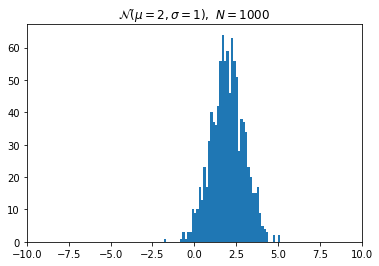

In [4]:
x = Gaussian(2.0, 1.0)
x

You can also pass the object to the `display` function to display the default representation:

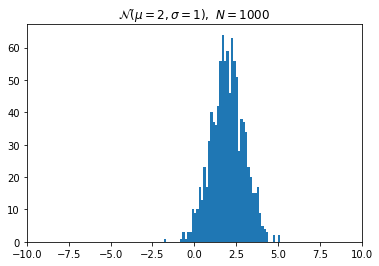

In [5]:
display(x)

While in both case only the LaTeX representation is shown, both are stored.

Use `display_png` to view the PNG representation:

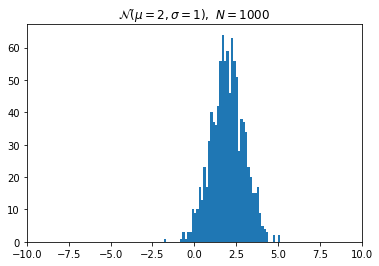

In [6]:
display_png(x)

<div class="alert alert-success">
It is important to note a subtle different between <code>display</code> and <code>display_png</code>. The former computes <em>all</em> representations of the object, and lets the notebook UI decide which to display. The later only computes the PNG representation.
</div>

Create a new Gaussian with different parameters:

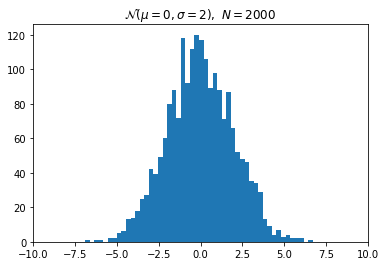

In [7]:
x2 = Gaussian(0, 2, 2000)
x2

You can then compare the two Gaussians by displaying their histograms:

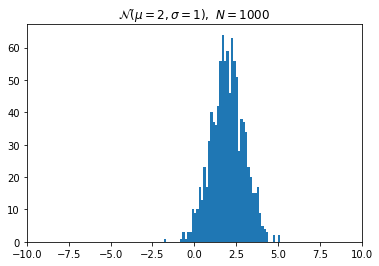

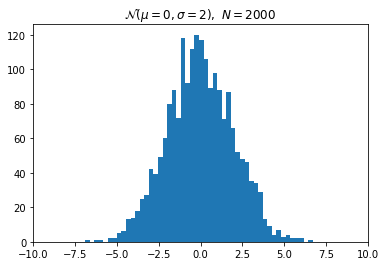

In [8]:
display_png(x)
display_png(x2)

Note that like `print`, you can call any of the `display` functions multiple times in a cell.

## Adding IPython display support to existing objects

When you are directly writing your own classes, you can adapt them for display in IPython by following the above approach.  But in practice, you often need to work with existing classes that you can't easily modify. We now illustrate how to add rich output capabilities to existing objects. We will use the NumPy polynomials and change their default representation to be a formatted LaTeX expression.

First, consider how a NumPy polynomial object renders by default:

In [9]:
p = np.polynomial.Polynomial([1,2,3], [-10, 10])
p

Polynomial([ 1.,  2.,  3.], [-10.,  10.], [-1,  1])

Next, define a function that pretty-prints a polynomial as a LaTeX string:

In [10]:
def poly_to_latex(p):
    terms = ['%.2g' % p.coef[0]]
    if len(p) > 1:
        term = 'x'
        c = p.coef[1]
        if c!=1:
            term = ('%.2g ' % c) + term
        terms.append(term)
    if len(p) > 2:
        for i in range(2, len(p)):
            term = 'x^%d' % i
            c = p.coef[i]
            if c!=1:
                term = ('%.2g ' % c) + term
            terms.append(term)
    px = '$P(x)=%s$' % '+'.join(terms)
    dom = r', $x \in [%.2g,\ %.2g]$' % tuple(p.domain)
    return px+dom

This produces, on our polynomial ``p``, the following:

In [11]:
poly_to_latex(p)

'$P(x)=1+2 x+3 x^2$, $x \\in [-10,\\ 10]$'

You can render this string using the `Latex` class:

In [12]:
from IPython.display import Latex
Latex(poly_to_latex(p))

<IPython.core.display.Latex object>

However, you can configure IPython to do this automatically by registering the `Polynomial` class and the `plot_to_latex` function with an IPython display formatter. Let's look at the default formatters provided by IPython:

In [14]:
ip = get_ipython()
for mime, formatter in ip.display_formatter.formatters.items():
    print('%24s : %s' % (mime, formatter.__class__.__name__))

              text/plain : PlainTextFormatter
               text/html : HTMLFormatter
           text/markdown : MarkdownFormatter
           image/svg+xml : SVGFormatter
               image/png : PNGFormatter
         application/pdf : PDFFormatter
              image/jpeg : JPEGFormatter
              text/latex : LatexFormatter
        application/json : JSONFormatter
  application/javascript : JavascriptFormatter


The `formatters` attribute is a dictionary keyed by MIME types. To define a custom LaTeX display function, you want a handle on the `text/latex` formatter:

In [15]:
ip = get_ipython()
latex_f = ip.display_formatter.formatters['text/latex']

The formatter object has a couple of methods for registering custom display functions for existing types.

In [16]:
help(latex_f.for_type)

Help on method for_type in module IPython.core.formatters:

for_type(typ, func=None) method of IPython.core.formatters.LatexFormatter instance
    Add a format function for a given type.
    
    Parameters
    -----------
    typ : type or '__module__.__name__' string for a type
        The class of the object that will be formatted using `func`.
    func : callable
        A callable for computing the format data.
        `func` will be called with the object to be formatted,
        and will return the raw data in this formatter's format.
        Subclasses may use a different call signature for the
        `func` argument.
        
        If `func` is None or not specified, there will be no change,
        only returning the current value.
    
    Returns
    -------
    oldfunc : callable
        The currently registered callable.
        If you are registering a new formatter,
        this will be the previous value (to enable restoring later).



In [17]:
help(latex_f.for_type_by_name)

Help on method for_type_by_name in module IPython.core.formatters:

for_type_by_name(type_module, type_name, func=None) method of IPython.core.formatters.LatexFormatter instance
    Add a format function for a type specified by the full dotted
    module and name of the type, rather than the type of the object.
    
    Parameters
    ----------
    type_module : str
        The full dotted name of the module the type is defined in, like
        ``numpy``.
    type_name : str
        The name of the type (the class name), like ``dtype``
    func : callable
        A callable for computing the format data.
        `func` will be called with the object to be formatted,
        and will return the raw data in this formatter's format.
        Subclasses may use a different call signature for the
        `func` argument.
        
        If `func` is None or unspecified, there will be no change,
        only returning the current value.
    
    Returns
    -------
    oldfunc : callable
  

In this case, we will use `for_type_by_name` to register `poly_to_latex` as the display function for the `Polynomial` type:

In [18]:
latex_f.for_type_by_name('numpy.polynomial.polynomial',
                                 'Polynomial', poly_to_latex)

Once the custom display function has been registered, all NumPy `Polynomial` instances will be represented by their LaTeX form instead:

In [19]:
p

Polynomial([ 1.,  2.,  3.], [-10.,  10.], [-1,  1])

In [20]:
p2 = np.polynomial.Polynomial([-20, 71, -15, 1])
p2

Polynomial([-20.,  71., -15.,   1.], [-1,  1], [-1,  1])

## More complex display with `_ipython_display_`

Rich output special methods and functions can only display one object or MIME type at a time. Sometimes this is not enough if you want to display multiple objects or MIME types at once. An example of this would be to use an HTML representation to put some HTML elements in the DOM and then use a JavaScript representation to add events to those elements.

**IPython 2.0** recognizes another display method, `_ipython_display_`, which allows your objects to take complete control of displaying themselves. If this method is defined, IPython will call it, and make no effort to display the object using the above described `_repr_*_` methods for custom display functions. It's a way for you to say "Back off, IPython, I can display this myself." Most importantly, your `_ipython_display_` method can make multiple calls to the top-level `display` functions to accomplish its goals.

Here is an object that uses `display_html` and `display_javascript` to make a plot using the [Flot](http://www.flotcharts.org/) JavaScript plotting library:

In [23]:
import json
import uuid
from IPython.display import display_javascript, display_html, display

class FlotPlot(object):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.uuid = str(uuid.uuid4())
    
    def _ipython_display_(self):
        json_data = json.dumps(list(zip(self.x, self.y)))
        display_html('<div id="{}" style="height: 300px; width:80%;"></div>'.format(self.uuid),
            raw=True
        )
        display_javascript("""
        require(["//cdnjs.cloudflare.com/ajax/libs/flot/0.8.2/jquery.flot.min.js"], function() {
          var line = JSON.parse("%s");
          console.log(line);
          $.plot("#%s", [line]);
        });
        """ % (json_data, self.uuid), raw=True)


In [24]:
import numpy as np
x = np.linspace(0,10)
y = np.sin(x)
FlotPlot(x, np.sin(x))